# Collating Traning Results

The training results are parsed and summarized in this notebook

In [59]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
from tqdm import tqdm

### Get the hyperparameters from the training logs.

In [60]:
# Path to train.log
path = "outputs/2024-04-11/07-26-56/train.log"

In [61]:
def read_log(path: Union[str, Path]):
    with open(path, "r") as f:
        lines = f.readlines()
    return lines

In [62]:
train_log = read_log(path)

In [63]:
tokens = ['src_data', 'model', 'embed_model', 'value_mode', 'task', 'transfer']

In [64]:
def create_pattern(token: str):
    return re.compile(r"'{}': '(\w+)'".format(token))

In [65]:
def parse_log(train_log: List[str], tokens: List[str]):
    hyperparams = {}
    for line in train_log:
        for tok in tokens:
            pattern = create_pattern(tok)
            match = pattern.search(line)
            if match:
                #print(match.group(1))
                hyperparams[tok] = match.group(1)
    return hyperparams


In [66]:
hyperparams = parse_log(train_log, tokens)

In [67]:
def get_trainlog_paths(root: Union[str, Path]):
    root = Path(root)
    return list(root.glob("*/*/train.log"))

In [68]:
def get_last_auprc(train_log: List[str], patterns: Dict[str, re.Pattern]):
    for line in train_log[::-1]:
        hit = patterns['auprc'].search(line)
        if hit:
            return hit.group(1)

In [69]:
def create_pattern_numerical(token: str):
    return re.compile(r"{}: (\d+(\.\d+)?)".format(token))

In [70]:
metrics = ['epoch','auroc', 'auprc', 'loss']
# create a pattern dictionay with the metrics as keys
patterns = {metric: create_pattern_numerical(metric) for metric in metrics}

In [71]:
def parse_experiment(root: Union[str, Path], tokens: List[str], patterns: Dict[str, re.Pattern]=None):
    l_trainlogs = get_trainlog_paths(root)
    df = pd.DataFrame()
    for log in l_trainlogs:
        train_log = read_log(log)
        hyperparams = parse_log(train_log, tokens)
        run = log.parent.name
        hyperparams['run'] = log.parent#/run
        if "done training" in train_log[-1]:
            hyperparams['done'] = True
        else:
            hyperparams['done'] = False
        if patterns:
            hyperparams['auprc'] = get_last_auprc(train_log, patterns)
        df = pd.concat([df, pd.DataFrame(hyperparams, index=[0])])
    if patterns:
        df['auprc'] = df['auprc'].astype(float)
        order = ['run', 'done', 'src_data', 'task', 'embed_model', 'model', 'value_mode', 'auprc']
    else:
        order = ['run', 'done', 'src_data', 'task', 'embed_model', 'model', 'value_mode']
    return df[order]

In [72]:
df_experiments = parse_experiment("outputs", tokens, patterns)

In [73]:
df_experiments.head(5)

,run,done,src_data,task,embed_model,model,value_mode,auprc
0,outputs/2024-04-13/07-13-12,False,mimiciii,mlm,NaN,descemb_rnn,NV,NaN
0,outputs/2024-04-13/07-13-22,False,eicu,mlm,NaN,descemb_rnn,NV,NaN
0,outputs/2024-04-13/07-17-36,False,mimiciii,mlm,NaN,descemb_rnn,NV,NaN
0,outputs/2024-04-13/07-26-31,False,mimiciii,mlm,NaN,descemb_rnn,NV,NaN
0,outputs/2024-04-13/07-44-35,False,mimiciii,mlm,NaN,descemb_rnn,NV,NaN


In [74]:
df_experiments.to_excel("outputs/experiments.xlsx", index=False)

### Parsing the train.log file for metrics

In [75]:
def extract_metrics(line: str, patterns: Dict[str, re.Pattern]):
    epoch = patterns['epoch'].search(line).group(1)
    loss = patterns['loss'].search(line).group(1)
    auroc = patterns['auroc'].search(line).group(1)
    auprc = patterns['auprc'].search(line).group(1)
    return int(epoch), float(loss), float(auroc), float(auprc)

In [76]:
def parse_experiment_metrics(root: Union[str, Path], patterns: Dict[str, re.Pattern]):
    l_trainlogs = get_trainlog_paths(root)
    print(f"Found {len(l_trainlogs)} train logs.")
    #df_metrics = pd.DataFrame(columns=['run', 'fold', 'epoch', 'loss', 'auroc', 'auprc'])
    dict_metrics = {'run': [], 'fold': [], 'epoch': [], 'loss': [], 'auroc': [], 'auprc': []}
    for log in tqdm(l_trainlogs):
        train_log = read_log(log)
        run = log.parent
        for line in train_log:
            if "[INFO]" in line:
                if "[train]" in line:
                    epoch, loss, auroc, auprc = extract_metrics(line, patterns)
                    dict_metrics['run'].append(run)
                    dict_metrics['fold'].append("train")
                    dict_metrics['epoch'].append(epoch)
                    dict_metrics['loss'].append(loss)
                    dict_metrics['auroc'].append(auroc)
                    dict_metrics['auprc'].append(auprc)
                elif "[valid]" in line:
                    epoch, loss, auroc, auprc = extract_metrics(line, patterns)
                    dict_metrics['run'].append(run)
                    dict_metrics['fold'].append("valid")
                    dict_metrics['epoch'].append(epoch)
                    dict_metrics['loss'].append(loss)
                    dict_metrics['auroc'].append(auroc)
                    dict_metrics['auprc'].append(auprc)
                elif "[test]" in line:
                    epoch, loss, auroc, auprc = extract_metrics(line, patterns)
                    dict_metrics['run'].append(run)
                    dict_metrics['fold'].append("test")
                    dict_metrics['epoch'].append(epoch)
                    dict_metrics['loss'].append(loss)
                    dict_metrics['auroc'].append(auroc)
                    dict_metrics['auprc'].append(auprc)
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [77]:
df_metrics = parse_experiment_metrics("outputs", patterns)

Found 137 train logs.


100%|██████████| 137/137 [00:00<00:00, 2081.85it/s]


In [78]:
df_metrics.run.unique()

array([PosixPath('outputs/2024-04-13/09-50-38'),
       PosixPath('outputs/2024-04-13/09-54-57'),
       PosixPath('outputs/2024-04-13/10-06-26'),
       PosixPath('outputs/2024-04-13/10-27-57'),
       PosixPath('outputs/2024-04-13/10-38-53'),
       PosixPath('outputs/2024-04-13/10-49-36'),
       PosixPath('outputs/2024-04-13/11-01-15'),
       PosixPath('outputs/2024-04-13/11-12-22'),
       PosixPath('outputs/2024-04-13/11-52-28'),
       PosixPath('outputs/2024-04-13/12-07-30'),
       PosixPath('outputs/2024-04-13/12-26-57'),
       PosixPath('outputs/2024-04-13/13-02-15'),
       PosixPath('outputs/2024-04-13/13-15-05'),
       PosixPath('outputs/2024-04-13/13-40-36'),
       PosixPath('outputs/2024-04-13/13-48-11'),
       PosixPath('outputs/2024-04-13/14-02-26'),
       PosixPath('outputs/2024-04-13/14-21-48'),
       PosixPath('outputs/2024-04-13/14-32-44'),
       PosixPath('outputs/2024-04-13/15-09-18'),
       PosixPath('outputs/2024-04-13/16-47-55'),
       PosixPath('ou

In [79]:
len(df_metrics)

3028

In [80]:
df_metrics.head(100)

,run,fold,epoch,loss,auroc,auprc
0,outputs/2024-04-13/09-50-38,train,1,0.654,0.509,0.045
1,outputs/2024-04-13/09-54-57,train,1,0.654,0.509,0.045
2,outputs/2024-04-13/09-54-57,valid,1,0.647,0.502,0.045
3,outputs/2024-04-13/09-54-57,test,1,1.462,0.505,0.043
4,outputs/2024-04-13/09-54-57,train,2,0.645,0.509,0.045
...,...,...,...,...,...,...
95,outputs/2024-04-13/10-27-57,valid,5,0.622,0.503,0.045
96,outputs/2024-04-13/10-27-57,test,5,1.404,0.504,0.043
97,outputs/2024-04-13/10-27-57,train,6,0.619,0.509,0.045
98,outputs/2024-04-13/10-27-57,valid,6,0.618,0.502,0.045


In [81]:
df_metrics.to_excel("outputs/metrics.xlsx", index=False)

In [82]:
def plot_metrics(df_metrics: pd.DataFrame, run: str, metrics: List[str] = ['loss', 'auroc', 'auprc']):
    run = Path(run)
    ncols = len(metrics)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 5))
    for i, metric in enumerate(metrics):
        for fold in ['train', 'valid', 'test']:
            ax = axes[i]
            df_metrics.loc[(df_metrics['fold']==fold) & (df_metrics['run']==run)].plot(x='epoch', y=metric, ax=ax, label=fold)
            ax.set_title(metric)
    fig.suptitle(run)
    plt.show()

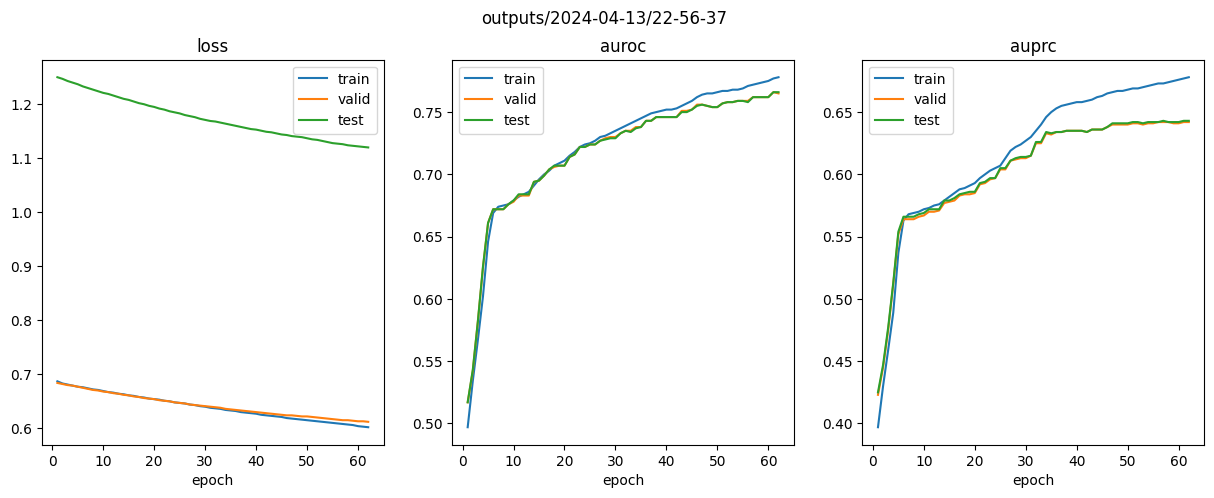

In [83]:
plot_metrics(df_metrics, 'outputs/2024-04-13/22-56-37')